# Plot Debugging

I am noticing some wierd things in the plots, and I am going to attempt to fix them on this branch:
- #41, it seems like the ball and the players are on different time scales?
- #14, the event only shows up for one frame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

Example plays are 
- 326
- 18

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


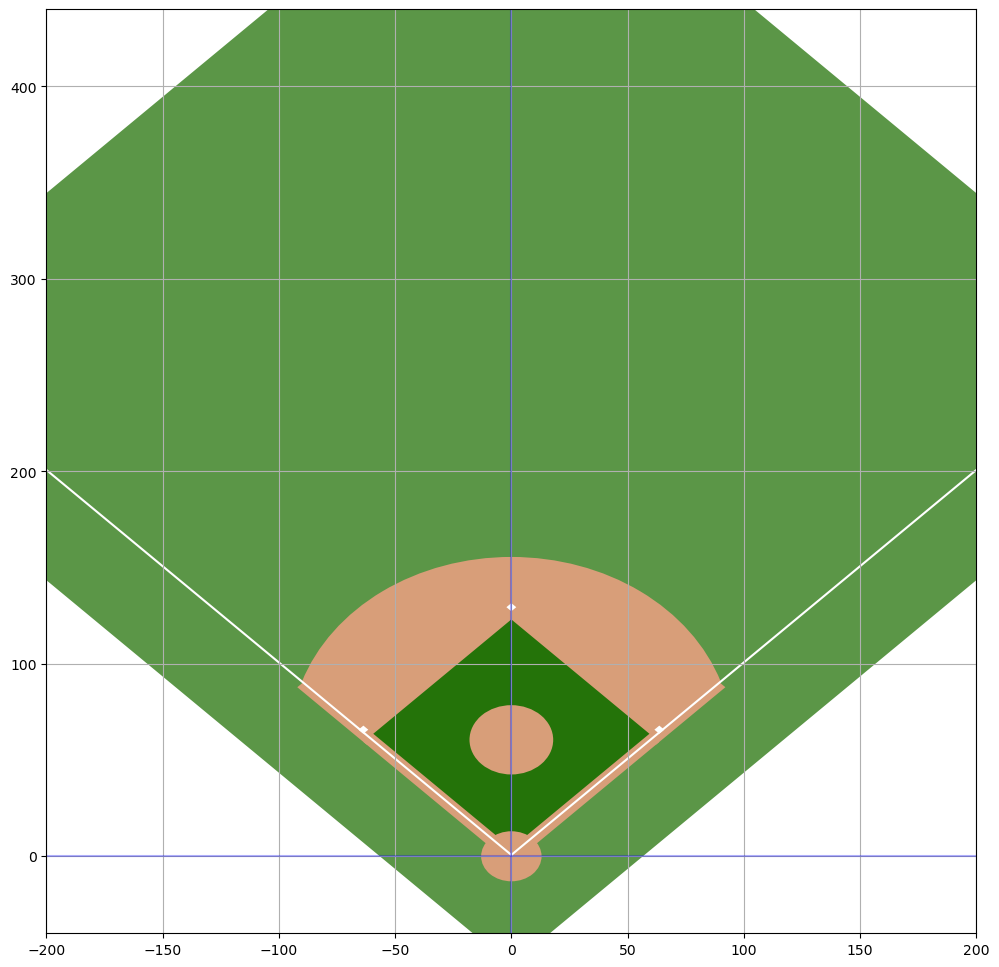

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [ ]:
bf_1903_01.clear_plot()

play_id = 18

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--debugging")

In [ ]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
ball_pos_1903_01 = bf_1903_01.game_obj.ball_pos_df.copy()



game_events_1903_01.head(5)

In [ ]:
game_events_1903_01[game_events_1903_01["play_id"] == 326]

In [ ]:
ball_pos_1903_01.loc[(ball_pos_1903_01["play_id"] == 326)
                       , :]

In [ ]:
player_pos_1903_01.loc[(player_pos_1903_01["play_id"] == 18) &
                       (player_pos_1903_01["player_position"] == 6), :]

In [ ]:
game_events_1903_01.loc[(game_events_1903_01["play_id"] == 326) &
                        (game_events_1903_01["event"].isin(["ball acquired", "throw (ball-in-play)"])), ]

In [ ]:
plt.close()

In [ ]:
## stretch the ball pos to the player pos

# trust the ball pos at ball acquired

# trust which time scale? I think the ball probably
play_id = 18

ball_acq = game_events_1903_01.loc[
    (game_events_1903_01["play_id"] == play_id) &
    (game_events_1903_01["event"] == "ball acquired")
    , "timestamp"
].values[0]


this_play_ball = ball_pos_1903_01.loc[ball_pos_1903_01["play_id"] == play_id]
this_play_ball["this_play_ms"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


first_ball_acq_x = ball_pos_1903_01.loc[ball_pos_1903_01["timestamp"] == ball_acq, "ball_position_x"]


this_play_players = player_pos_1903_01.loc[
    (player_pos_1903_01["play_id"] == play_id) &
    (player_pos_1903_01["player_position"] == 6)
    , :]

this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()


overlap_ms_players = this_play_players.loc[
    (abs(this_play_players["field_x"] - first_ball_acq_x.values[0]) < 0.1)
    , "this_play_ms"].values[0]


overlap_ms_ball = this_play_ball.loc[this_play_ball["timestamp"] == ball_acq, "this_play_ms"].values[0]


time_delta = overlap_ms_players - overlap_ms_ball

In [ ]:
time_delta

In [ ]:
f, ax = plt.subplots()



ax.plot(this_play_players["this_play_ms"], this_play_players["field_x"], color = "orange") 
ax.plot(this_play_ball["this_play_ms"]+time_delta, this_play_ball["ball_position_x"], color = "blue") 


### Do the above procedure for every play!

In [ ]:
def line_up_ball_and_players():
    pass

In [ ]:
overlap_ms_ball

In [ ]:
this_play_ball

In [ ]:
f, ax = plt.subplots()

play_id = 38

thirdbaseman_df = player_pos_1903_01.loc[(player_pos_1903_01["play_id"] == play_id) &
                       (player_pos_1903_01["player_position"] == 5), :]


ball_df = ball_pos_1903_01.loc[(ball_pos_1903_01["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"] + 3100, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

In [ ]:
ball_df

In [ ]:
thirdbaseman_df

### I THINK IT IS JUST A CONSTANT FACTOR PER GAME?
- It seems like most games this is not a problem from looking at some gifs?

### Double check whether it is a constant factor per game by running this

In [7]:
bf_09 = Baseball_Field("1903_09_TeamNJ_TeamB")

Distance between ball and player is large on average, should maybe clean up 12.947763118481664


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


In [12]:
game_events_09 = bf_09.game_obj.game_events_df.copy()
game_info_09 = bf_09.game_obj.game_info_df.copy()
player_pos_09 = bf_09.game_obj.new_player_pos.copy()
ball_pos_09 = bf_09.game_obj.ball_pos_df.copy()


In [18]:
game_events_09[game_events_09["event"] == "throw (ball-in-play)"].head(3)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo
48,1903_09_TeamNJ_TeamB,15,3,16,344834,6,3,throw (ball-in-play),2.0,ball acquired,345784.0,2.0,ball acquired,343484.0,7.418955,2.233167,73.630919
80,1903_09_TeamNJ_TeamB,24,4,25,632534,7,3,throw (ball-in-play),2.0,ball acquired,634084.0,2.0,ball acquired,631434.0,2.915168,9.609680,62.241388
125,1903_09_TeamNJ_TeamB,38,6,39,990484,7,3,throw (ball-in-play),2.0,ball acquired,992134.0,2.0,ball acquired,988584.0,5.779574,12.114775,58.014101


In [29]:
bf_09.clear_plot()

play_id = 24

# bf_09.plot_all_components(play_id=play_id)
# bf_09.fig

# bf_09.create_gif(play_id=play_id, tag="--debugging, markers are off")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [22]:
## stretch the ball pos to the player pos

# trust the ball pos at ball acquired

# trust which time scale? I think the ball probably
play_id = 15

ball_acq = game_events_09.loc[
    (game_events_09["play_id"] == play_id) &
    (game_events_09["event"] == "ball acquired")
    , "timestamp"
].values[0]


this_play_ball = ball_pos_09.loc[ball_pos_09["play_id"] == play_id]
this_play_ball["this_play_ms"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


first_ball_acq_x = ball_pos_09.loc[ball_pos_09["timestamp"] == ball_acq, "ball_position_x"]


this_play_players = player_pos_09.loc[
    (player_pos_09["play_id"] == play_id) &
    (player_pos_09["player_position"] == 6)
    , :]

this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()


overlap_ms_players = this_play_players.loc[
    (abs(this_play_players["field_x"] - first_ball_acq_x.values[0]) < 1)
    , "this_play_ms"].values[0]


overlap_ms_ball = this_play_ball.loc[this_play_ball["timestamp"] == ball_acq, "this_play_ms"].values[0]


time_delta = overlap_ms_players - overlap_ms_ball

In [23]:
time_delta

3050

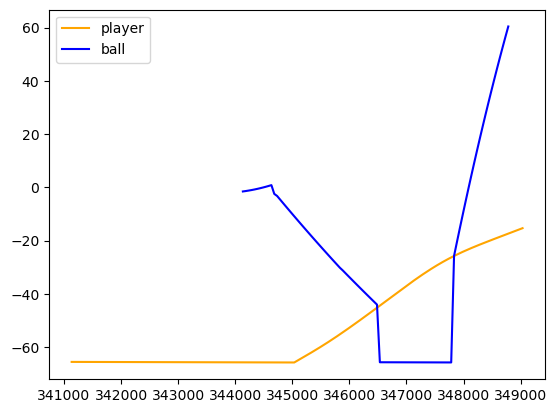

In [26]:
bf_09.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 15

thirdbaseman_df = player_pos_09.loc[(player_pos_09["play_id"] == play_id) &
                       (player_pos_09["player_position"] == 6), :]


ball_df = ball_pos_09.loc[(ball_pos_09["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"]+3000, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

### The one has a smaller dist Which game: 1900_03_TeamKJ_TeamB

In [37]:
# Check whether 3000 is still the correct buffer?
bf_03 = Baseball_Field("1903_05_TeamND_TeamA2")

Distance between ball and player is large on average, should maybe clean up 14.67974023000007


In [38]:
game_events_03 = bf_03.game_obj.game_events_df.copy()
game_info_03 = bf_03.game_obj.game_info_df.copy()
player_pos_03 = bf_03.game_obj.new_player_pos.copy()
ball_pos_03 = bf_03.game_obj.ball_pos_df.copy()


In [39]:
game_events_03[game_events_03["event"] == "throw (ball-in-play)"].head(3)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo
55,1903_05_TeamND_TeamA2,17,4,17,372762,5,3,throw (ball-in-play),2.0,ball acquired,373662.0,2.0,ball acquired,371162.0,46.007032,4.625682,67.025473
57,1903_05_TeamND_TeamA2,17,4,17,374162,4,3,throw (ball-in-play),2.0,ball acquired,375062.0,2.0,ball acquired,373662.0,2.225023,6.558247,67.812572
165,1903_05_TeamND_TeamA2,46,11,46,1308512,7,3,throw (ball-in-play),2.0,ball acquired,1310162.0,2.0,ball acquired,1307762.0,13.101054,11.570769,67.604171


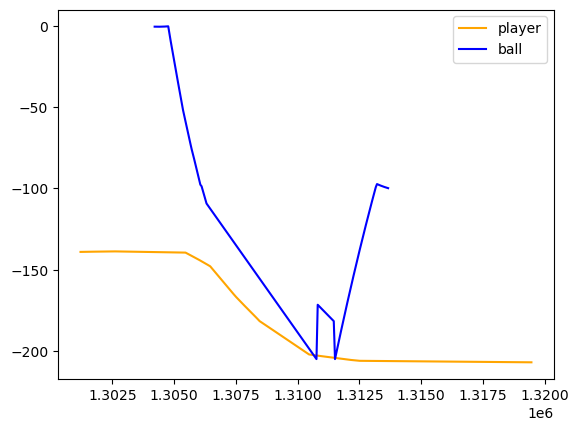

In [48]:
bf_03.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 46

thirdbaseman_df = player_pos_03.loc[(player_pos_03["play_id"] == play_id) &
                       (player_pos_03["player_position"] == 7), :]


ball_df = ball_pos_03.loc[(ball_pos_03["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"]+3000, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

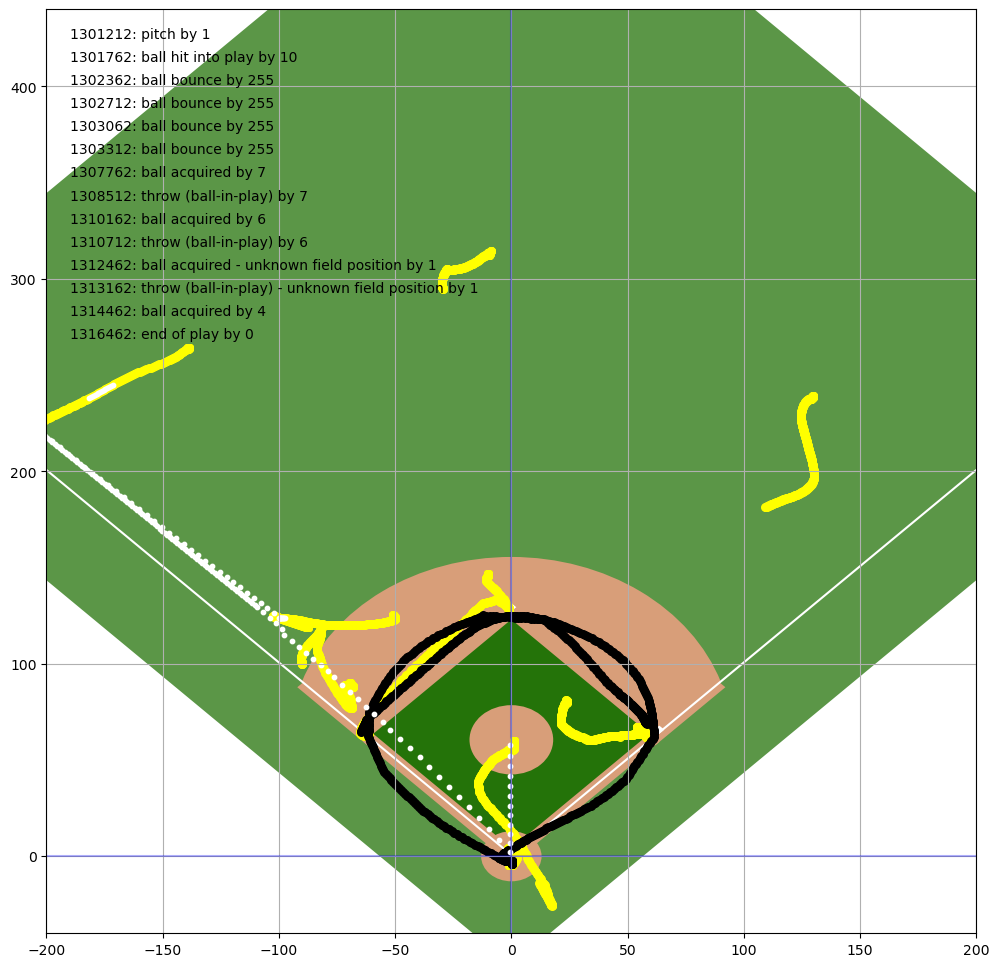

In [51]:
bf_03.clear_plot()

play_id = 46

bf_03.plot_all_components(play_id=play_id)
bf_03.fig

# bf_03.create_gif(play_id=play_id, tag="--debugging, no clue")

## See a play that works, before I go messing with things

1903_23_TeamNA_TeamA1_play148--steal, not picked

In [ ]:
bf_23 = Baseball_Field("1903_23_TeamNA_TeamA1")

In [ ]:
game_events_23 = bf_23.game_obj.game_events_df.copy()
game_info_23 = bf_23.game_obj.game_info_df.copy()
player_pos_23 = bf_23.game_obj.new_player_pos.copy()
ball_pos_23 = bf_23.game_obj.ball_pos_df.copy()

game_events_23.head(5)

In [ ]:
bf_23.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 148

thirdbaseman_df = player_pos_23.loc[(player_pos_23["play_id"] == play_id) &
                       (player_pos_23["player_position"] == 2), :]


ball_df = ball_pos_23.loc[(ball_pos_23["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"], ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

In [ ]:
check_positions_when_acquired(game_events_23, ball_pos_23, player_pos_23)

In [ ]:
plt.close()

In [ ]:
game_events_23[game_events_23["event"] == "throw (ball-in-play)"]

In [ ]:
## make some gifs to see if I need to time correct?

bf_23.clear_plot()

play_id = 196

# bf_23.plot_all_components(play_id=play_id)
# bf_23.fig

# bf_23.create_gif(play_id=play_id, tag="--debugging")

## See how many I would like to line up
to see if it is worth writing that function to line things up
- there are 7 of the games that aren't erroring, so I think I should do this

In [4]:
all_games = get_all_game_strs()

Gathered a list of 97 games


In [5]:
for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))
    
    g = Game(which_game)


Which game: 1903_01_TeamNE_TeamA2
Distance between ball and player is large on average, should maybe clean up 12.199183415462679
Which game: 1903_16_TeamNI_TeamA3
Which game: 1902_02_TeamMG_TeamA3
Which game: 1903_08_TeamNJ_TeamB
Which game: 1900_08_TeamKL_TeamB
Which game: 1903_23_TeamNA_TeamA1
Which game: 1901_08_TeamLK_TeamB
Which game: 1902_22_TeamMA_TeamA1
Which game: 1902_12_TeamMI_TeamA3
Which game: 1903_11_TeamNC_TeamA1
Which game: 1900_07_TeamKL_TeamB


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1903_17_TeamNI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1903_27_TeamNK_TeamB
Which game: 1901_12_TeamLJ_TeamB
Which game: 1900_09_TeamKK_TeamB
Which game: 1901_01_TeamLG_TeamA3
Which game: 1900_03_TeamKJ_TeamB
Distance between ball and player is large on average, should maybe clean up 6.403561421830762
Which game: 1903_22_TeamNA_TeamA1
Which game: 1902_16_TeamMD_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1903_32_TeamNB_TeamA1
Which game: 1901_07_TeamLK_TeamB
Which game: 1902_23_TeamMA_TeamA1
Which game: 1902_15_TeamMK_TeamB
Which game: 1902_04_TeamML_TeamB
Which game: 1903_24_TeamNA_TeamA1
Which game: 1903_03_TeamNE_TeamA2
Which game: 1903_12_TeamNC_TeamA1
Which game: 1903_09_TeamNJ_TeamB
Distance between ball and player is large on average, should maybe clean up 12.947763118481664


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1903_19_TeamNL_TeamB
Which game: 1901_02_TeamLG_TeamA3
Which game: 1903_31_TeamNB_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1901_09_TeamLK_TeamB
Which game: 1902_10_TeamMI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1903_02_TeamNE_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1902_26_TeamMC_TeamA1
Which game: 1903_26_TeamNK_TeamB
Which game: 1902_24_TeamMA_TeamA1
Which game: 1902_01_TeamMG_TeamA3
Which game: 1901_18_TeamLH_TeamA3
Which game: 1901_03_TeamLG_TeamA3
Which game: 1900_06_TeamKL_TeamB
Which game: 1902_14_TeamMK_TeamB
Which game: 1902_05_TeamML_TeamB
Which game: 1902_14_TeamMD_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1903_30_TeamNB_TeamA1
Which game: 1902_11_TeamMI_TeamA3
Which game: 1903_05_TeamND_TeamA2
Distance between ball and player is large on average, should maybe clean up 14.67974023000007
Which game: 1903_26_TeamNH_TeamA3
Which game: 1903_15_TeamNG_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1900_04_TeamKK_TeamB
Which game: 1903_20_TeamNL_TeamB
Which game: 1902_06_TeamML_TeamB
Which game: 1903_18_TeamNI_TeamA3
Which game: 1902_09_TeamMJ_TeamB
Which game: 1901_14_TeamLL_TeamB
Which game: 1900_01_TeamKJ_TeamB
Which game: 1902_26_TeamMH_TeamA3
Which game: 1901_10_TeamLJ_TeamB
Which game: 1903_25_TeamNK_TeamB
Which game: 1903_14_TeamNG_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered 

Which game: 1902_29_TeamMF_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1902_28_TeamMC_TeamA1
Which game: 1901_04_TeamLI_TeamA3
Which game: 1903_28_TeamNF_TeamA2
Which game: 1901_16_TeamLH_TeamA3
Which game: 1902_25_TeamMH_TeamA3
Which game: 1900_05_TeamKK_TeamB
Distance between ball and player is large on average, should maybe clean up 6.6387674989651195
Which game: 1903_07_TeamND_TeamA2
Which game: 1903_04_TeamNC_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1902_17_TeamMB_TeamA1
Which game: 1902_08_TeamMJ_TeamB
Which game: 1903_10_TeamNJ_TeamB
Which game: 1903_29_TeamNF_TeamA2
Which game: 1901_15_TeamLL_TeamB
Distance between ball and player is large on average, should maybe clean up 5.3524560073690175
Which game: 1903_13_TeamNG_TeamA3
Which game: 1903_21_TeamNL_TeamB
Which game: 1903_30_TeamNF_TeamA2
Which game: 1903_06_TeamND_TeamA2
Distance between ball and player is large on average, should maybe clean up 15.614163808346984
Which game: 1903_25_TeamNH_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:815: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


Which game: 1901_11_TeamLJ_TeamB
Which game: 1902_31_TeamMF_TeamA2
